# **Deep Research with Bing Search & Scraping**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow now includes a dedicated scraping phase for extracting and cleaning web content:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Web Content Scraping** - Extracting, cleaning, and filtering relevant content from web pages using a ScraperAgent
4. **Content Analysis** - Summarizing scraped results and extracting key insights
5. **Report Generation** - Creating detailed research reports with proper citations
6. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- WebScraperAgent - Extracts, cleans, and filters relevant content from web pages
- SummaryAgent - Extracts key insights from scraped content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

## Required Environment Variables

This notebook requires the following environment variables in your `.env` file:

```bash
# Azure OpenAI Configuration
AOAI_ENDPOINT=your_azure_openai_endpoint
AOAI_KEY=your_azure_openai_api_key
AOAI_API_VERSION=2024-02-01  # Optional, defaults to this value

# Model Deployment Names
reasoningModel=your_reasoning_model_deployment_name  # e.g., o1-preview
chatModel=your_chat_model_deployment_name  # e.g., gpt-4o

# Azure AI Projects Configuration
PROJECT_ENDPOINT=your_azure_ai_project_endpoint

# Bing Search Agent (pre-created in Azure AI Foundry)
bingSearchAgentID=your_bing_search_agent_id
BING_CONNECTION_NAME=your_bing_connection_name  # Only needed if creating agent inline
```

**Note:** This notebook extends notebook 01 by adding web scraping capabilities. Like notebook 01, it creates agents inline using the OpenAI Agents SDK, except for the Bing Search agent which must be pre-created in Azure AI Foundry.

In [1]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [2]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [3]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class ScrapedWebPage(BaseModel):
    url: str = Field(..., description="The original URL that was scraped")
    title: Optional[str] = Field(None, description="The page title (if available, else None)")
    main_content: Optional[str] = Field(None, description="The main textual content of the page, cleaned and potentially truncated (if available, else None)")
    source: Optional[str] = Field(None, description="The name of the source (if available, else None)")
    published_date: Optional[str] = Field(None, description="YYYY-MM-DD (if available, else None)")
    scrape_error: Optional[str] = Field(None, description="Error message if scraping failed, else None")
    # Fields below might be added by the agent based on instructions, not the tool directly
    extraction_method: Optional[str] = Field(None, description="How content was extracted (e.g., 'tool_extracted', 'agent_filtered')") 
    relevance_score_agent: Optional[float] = Field(None, description="Agent's assessment of relevance (0-10)")
    matched_sections: Optional[List[str]] = Field(None, description="Sections identified by the agent as relevant")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [4]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

### Creating the Bing Search Agent (One-time Setup)

The following cell will **create** an **Azure AI Agent** with Bing Search capabilities. You only need to run this cell **once** to create the agent, then save its ID to your `.env` file as `bingSearchAgentID`.

If you already have a Bing Search agent created, skip this cell and use the next cell to update its instructions instead.

In [5]:
from azure.ai.agents.models import BingGroundingTool

import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_connection = project_client.connections.get(
    name=os.getenv("BING_CONNECTION_NAME")
)

bing_tool = BingGroundingTool(connection_id=bing_connection.id)

bing_search_agent = project_client.agents.create_agent(
    name="bingSearchAgent",
    description="Agent to perform web searches using Bing.",
    model=os.getenv("chatModel"),
    temperature=0.5,
    tools=bing_tool.definitions,
    instructions=f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
    """.strip()
)

### Updating Existing Bing Search Agent

If you already have a Bing Search agent (with its ID in your `.env` file), run this cell to update its instructions with today's date. This ensures the agent has current date awareness for time-sensitive queries.

In [6]:
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-11-10.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


### Creating OpenAI Agents

The following agents are created inline using the OpenAI Agents SDK:
- **PlannerAgent** - Creates research plans
- **WebScraperAgent** - Scrapes and filters web content (new in this notebook)
- **SummaryAgent** - Summarizes scraped content
- **ResearchAgent** - Generates comprehensive reports
- **PeerReviewAgent** - Provides quality feedback

These agents are created fresh each time you run the notebook.

In [7]:
from agents import (
    Agent,
    ModelSettings
)

from common.utils_scraping import scrape_web_page

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.

    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 4 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 2 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

web_scraper_agent = Agent(
    name="WebScraperAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are a robust, context-aware web scraping specialist. Your primary tool is 'scrape_web_page'.

    Your input is a JSON string containing: 'url', 'subtopic', 'user_query', 'search_result_title', 'visited_urls', and 'max_content_length'. Parse this JSON to get the necessary information.

    **Workflow:**
    1.  **Parse Input:** Extract 'url', 'user_query', 'subtopic', 'search_result_summary', and 'max_content_length' from the input JSON string.
    2.  **Call Scraping Tool:** Call the `scrape_web_page` tool with the 'url' and 'max_content_length'.
    3.  **Analyze Tool Output:** Receive the dictionary from the tool containing `url`, `title`, `main_content`, `source`, `published_date`, `scrape_error`.
    4.  **Contextual Filtering (If Content Exists and No Error):**
        - If `scrape_error` is None and `main_content` exists:
            - Review the `main_content`.
            - Use the `user_query`, `subtopic`, and `search_result_summary` to identify ONLY the most relevant paragraphs or sections.
            - If the entire `main_content` seems relevant or is short, keep it all.
            - If filtering, replace `main_content` with ONLY the relevant extracted parts. Set `extraction_method` to 'agent_filtered'.
            - Estimate a `relevance_score_agent` (0-10).
            - Optionally list `matched_sections`.
        - If `scrape_error` is present, ensure the `scrape_error` field in your output reflects the tool's error.
    5.  **Format Output:** Return a SINGLE JSON object matching the `ScrapedWebPage` Pydantic model, including all fields based on the tool's output and your filtering. If the tool failed, `main_content` should be None/empty, and `scrape_error` should be set.
    6.  **Return JSON object:** Return ONLY the final object formatted as a single, valid JSON. Do NOT add any explanatory text before or after the JSON.

    **Constraints:**
    - Your final output MUST be ONLY a valid JSON representing the scraped and processed data.
    - Adhere strictly to the field names defined in the conceptual `ScrapedWebPage` structure when creating the JSON.
    - Prioritize accuracy and relevance based on the provided context.
    """,
    model=chatModel,
    model_settings=chatModelSettings,
    tools=[scrape_web_page],
    output_type=ScrapedWebPage
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)


peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [8]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Web Content Scraping** → WebScraperAgent extracts, cleans, and filters relevant content from web pages
5. **Analysis** → SummaryAgent processes scraped results, extracting key insights while preserving technical details
6. **Synthesis** → ResearchAgent creates well-structured report with proper citations
7. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
8. **Revision** → If needed, research report undergoes improvement cycles based on feedback
9. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

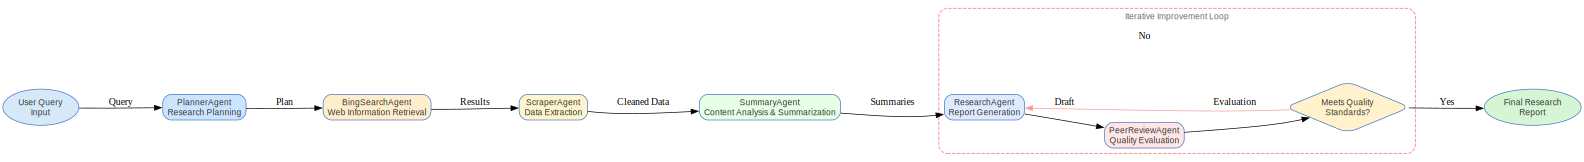

In [9]:
from common.helper import create_research_workflow_diagram_scraper

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram_scraper()
workflow_diagram

Let's start with a sample research query.

In [10]:
# user_query="What big industries will AI have the most affect on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [11]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [12]:
plan.final_output.research_tasks[0].search_queries

['What is classical machine learning?',
 'Definition of deep learning in artificial intelligence',
 'What is generative AI and how does it work?',
 'Difference between classical ML, deep learning, and generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. Multiple search queries are sent to gather diverse perspectives.
2. The agent returns structured search results with titles, summaries, relevance scores, and URLs.
3. Results are organized by subtopic for further processing.

This step leverages Azure AI Projects with Bing Search integration to identify promising sources.

In [13]:
import os
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            message = project_client.agents.messages.create(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.runs.create_and_process(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 4/4 [04:43<00:00, 70.89s/it]


In [14]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 16

Actually total search queries: 16



### Step 3: Web Content Scraping

The WebScraperAgent processes the URLs and metadata returned by the BingSearchAgent. For each subtopic:

1. Only URLs with a high enough relevance score are selected for scraping.
2. The WebScraperAgent visits each selected URL and extracts the most relevant content, guided by the user query, subtopic, and search result summary.
3. Extracted content is cleaned, deduplicated, and enriched with metadata such as title, source, published date, and extraction method.
4. The resulting structured data is organized by subtopic for downstream analysis and summarization.

This step ensures that only the most promising and contextually relevant web content is collected, providing a high-quality foundation for subsequent summarization and synthesis.

In [15]:
from typing import Set

class ScraperAgentInput(BaseModel):
    url: str
    subtopic: str
    user_query: str
    search_result_title: str
    visited_urls: Set[str] = Field(default_factory=set)
    max_content_length: int = 4000

In [16]:
# TODO: Implement a threshold for relevance score 

# --- Scraping Phase ---
urls_to_process_map = {}

print("Preparing scrape tasks...")
for subtopic_result in search_results:
    subtopic = subtopic_result["subtopic"]
    for query_result in subtopic_result["queries"]:
        query = query_result["query"]
        for result in query_result["results"]:
            if result["url"] not in urls_to_process_map:
            # if result.relevance_score >= MIN_RELEVANCE_SCORE and result.url not in urls_to_process_map:
                urls_to_process_map[result["url"]] = {
                    "subtopic": subtopic,
                    "query": query,
                    "search_result_title": result["title"]
                }

visited_urls_tracker = set(urls_to_process_map.keys())
print(f"Found {len(urls_to_process_map)} unique URLs above threshold to scrape.")

Preparing scrape tasks...
Found 63 unique URLs above threshold to scrape.


In [17]:
from itertools import islice

MAX_SCRAPE_CONTENT_LENGTH = 4000 # Max characters for scrape tool

scrape_tasks = []
num_urls_to_scrape = len(urls_to_process_map)

for url, context in tqdm(islice(urls_to_process_map.items(), num_urls_to_scrape),
                         desc="Preparing scrape tasks",
                         total=num_urls_to_scrape):
    agent_input_model = ScraperAgentInput(
        url=url,
        subtopic=context["subtopic"],
        user_query=context["query"],
        search_result_title=context["search_result_title"],
        visited_urls=visited_urls_tracker,
        max_content_length=MAX_SCRAPE_CONTENT_LENGTH
    )

    scrape_response = await Runner().run(
        starting_agent=web_scraper_agent,
        input=f"Scrape data from the provided URL: {agent_input_model.model_dump_json()}"
    )
    scrape_tasks.append(scrape_response.final_output)

Preparing scrape tasks: 100%|██████████| 63/63 [08:37<00:00,  8.21s/it]


### Step 4: Content Analysis and Summarization

For each scraped result, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the cleaned web content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms high-quality scraped data into structured, information-rich summaries that will form the basis of our research report.

In [18]:
from common.utils_summary import collect_contents_and_citations, summarize_content
summarize_per_webpage = False  # True will summarize per web page, False will summarize per subtopic

# Build a lookup for scraped content (using attribute access)
scraped_content_by_url = {
    item.url: item.main_content
    for item in scrape_tasks
    if getattr(item, "main_content", None)
}

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    contents, citations = collect_contents_and_citations(subtopic_result, scraped_content_by_url)
    summaries = await summarize_content(contents, summary_agent, Runner, summarize_per_webpage)
    if summarize_per_webpage:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })
    else:
        mapped_chunks.append({
            "subtopic": subtopic_result["subtopic"],
            "summaries": summaries,
            "citations": citations
        })

# Filter out empty summaries
mapped_chunks = [c for c in mapped_chunks if c['summaries']]

Summarizing subtopics: 100%|██████████| 4/4 [01:36<00:00, 24.18s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [19]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan.final_output, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [20]:
from agents import HandoffCallItem

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [21]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Comprehensive Analysis and Comparison of Classical Machine Learning, Deep Learning, and Generative AI

## Introduction

Artificial intelligence (AI) has undergone a remarkable transformation over the past several decades, evolving from rule-based systems to sophisticated models capable of autonomous learning and creative synthesis. This progression has given rise to distinct but interconnected subfields: classical machine learning (ML), deep learning (DL), and generative AI (GenAI). Each approach embodies unique methodologies, capabilities, and applications, yet their boundaries often blur, reflecting a continuum of technological advancement. Understanding the definitions, methodologies, applications, strengths, limitations, and interrelationships among these paradigms is essential for researchers, practitioners, and decision-makers seeking to harness AI's full potential. This report provides an in-depth, authoritative analysis of these three pillars of modern AI, integrating quantitative data, technical details, and comparative insights to illuminate their roles in contemporary and future innovation.

## 1. Definitions and Core Concepts

### 1.1 Artificial Intelligence: The Umbrella Concept

Artificial Intelligence (AI) refers broadly to computer systems designed to simulate human intelligence, enabling machines to perform tasks such as reasoning, learning, perception, and decision-making. AI encompasses a spectrum of technologies, from expert systems and symbolic reasoning to data-driven learning algorithms. Its primary goal is to create systems that can adapt to new information, solve complex problems, and interact naturally with humans and their environments [1].

### 1.2 Classical Machine Learning

Classical machine learning (ML) is a subset of AI focused on algorithms that learn from data to make predictions or decisions without being explicitly programmed for each task. Classical ML typically relies on statistical methods and manual feature engineering, where domain experts select and transform input variables to optimize model performance. Algorithms such as decision trees, support vector machines (SVMs), logistic regression, linear regression, and clustering are foundational to classical ML. These models excel with structured data and are well-suited for tasks where interpretability, efficiency, and limited data are paramount [2][3].

Classical ML models are generally categorized as discriminative, meaning they learn boundaries between classes for classification or regression tasks. Their strengths lie in their simplicity, lower computational requirements, and ease of implementation. However, they struggle with complex or unstructured data and lack the adaptability of more advanced AI paradigms.

### 1.3 Deep Learning

Deep learning (DL) represents a significant leap within ML, utilizing artificial neural networks with multiple layers—often called multilayered or "deep" networks. Inspired by biological neuroscience, DL models stack artificial neurons into layers, enabling the system to learn complex hierarchical features from raw data. Unlike classical ML, DL automates feature extraction, reducing the need for manual intervention and allowing models to handle large, unstructured datasets such as images, audio, and text [4][5].

The depth of a neural network is measured by its credit assignment path (CAP), which tracks the chain of transformations from input to output. Deep learning is generally considered to involve CAP depths greater than two. Architectures such as convolutional neural networks (CNNs), recurrent neural networks (RNNs), and transformers have enabled breakthroughs in computer vision, speech recognition, and natural language processing. DL models require significant computational resources and large labeled datasets but achieve state-of-the-art results in many domains.

### 1.4 Generative AI

Generative AI (GenAI) is a specialized branch of AI, typically built atop deep learning architectures, that focuses on creating new content rather than merely analyzing or predicting. Generative models, such as Generative Adversarial Networks (GANs), Variational Autoencoders (VAEs), and transformer-based architectures (e.g., GPT, Llama), learn the underlying probability distribution of training data and can generate novel outputs that closely resemble the original data [6][7].

GenAI models require vast amounts of unstructured data and significant computational resources for training, often involving thousands of GPUs and weeks of processing. The resulting foundation models—large neural networks with billions of parameters—can autonomously generate text, images, audio, video, and even multimodal content in response to user prompts. Generative AI differs fundamentally from discriminative AI: while discriminative models classify or label input data based on learned boundaries, generative models synthesize new samples by extrapolating from learned patterns.

### 1.5 Evolution and Interrelationships

The evolution from classical ML to DL and GenAI reflects a shift from manual, rule-based systems to autonomous, data-driven models capable of complex reasoning and content creation. Classical ML remains relevant for structured, interpretable, and resource-efficient tasks, while DL and GenAI unlock new possibilities for handling unstructured data and automating creative processes. The distinctions between these fields—structured vs. unstructured data, manual vs. automatic feature extraction, prediction vs. synthesis—are critical for selecting the appropriate AI technology for a given application [8].

#### Table 1: Hierarchical Breakdown of AI Paradigms

| Level           | Paradigm               | Key Characteristics                          |
|-----------------|-----------------------|----------------------------------------------|
| AI              | Artificial Intelligence| Reasoning, learning, perception, problem-solving |
| ML (subset of AI)| Machine Learning      | Data-driven learning, manual feature engineering |
| DL (subset of ML)| Deep Learning         | Multilayer neural networks, automatic feature extraction |
| GenAI (built on DL)| Generative AI        | Content synthesis, large models, multimodal outputs |

## 2. Methodologies and Algorithms

### 2.1 Classical Machine Learning Methodologies

Classical ML is characterized by its use of statistical and computational algorithms to parse data, learn from it, and make predictions or decisions. The methodologies are grounded in mathematical rigor and often require manual intervention for feature selection and engineering. Key algorithms include:

- **Linear Regression:** Predicts continuous values based on linear relationships between input variables.
- **Logistic Regression:** Used for binary classification, modeling the probability of a categorical outcome.
- **Decision Trees:** Hierarchical models that split data based on feature thresholds, offering interpretability and rule-based classification.
- **Support Vector Machines (SVMs):** Identify optimal boundaries between classes in high-dimensional spaces.
- **K-Nearest Neighbors (KNN):** Instance-based learning for classification and regression based on proximity in feature space.
- **Naive Bayes:** Probabilistic classification assuming feature independence.
- **Ensemble Methods:** Combine multiple models (e.g., random forests, gradient boosting) to improve accuracy and robustness.
- **Clustering Algorithms:** Group data into clusters based on similarity (e.g., k-means, hierarchical clustering).

Evaluation metrics for classical ML include accuracy, precision, recall, F1-score, and ROC-AUC, providing quantitative measures of model performance [9][10].

### 2.2 Deep Learning Architectures and Algorithms

Deep learning leverages neural networks with multiple layers to automatically extract hierarchical features from raw data. The architecture of a typical DL model includes an input layer, several hidden layers, and an output layer. Training involves adjusting millions or billions of parameters—weights and biases—using large datasets and iterative optimization.

#### Key Deep Learning Architectures:

- **Convolutional Neural Networks (CNNs):** Specialized for spatial data (images, video), using convolutional layers to capture local patterns.
- **Recurrent Neural Networks (RNNs):** Designed for sequential data (time series, text), maintaining memory of previous inputs.
- **Long Short-Term Memory (LSTM) Networks:** Address the vanishing gradient problem in RNNs, enabling learning of long-term dependencies.
- **Autoencoders:** Unsupervised models for dimensionality reduction and feature learning.
- **Generative Adversarial Networks (GANs):** Consist of a generator and discriminator in a competitive framework, enabling realistic content generation.
- **Transformers:** Utilize self-attention mechanisms for parallel processing of sequences, foundational for large language models (LLMs) [11][12].

Optimization techniques such as Stochastic Gradient Descent (SGD), AdaGrad, RMSProp, and Adam are crucial for training deep networks, each offering trade-offs in convergence speed, stability, and adaptability to sparse or noisy gradients. DL models require significant computational resources and large labeled datasets but achieve state-of-the-art results in computer vision, speech recognition, and natural language processing [13].

### 2.3 Generative AI Algorithms

Generative AI builds on deep learning architectures to create new, original content. The methodologies focus on learning the underlying probability distribution of training data and generating new samples from it.

#### Core Generative AI Models:

- **Generative Adversarial Networks (GANs):** Two neural networks (generator and discriminator) compete, with the generator creating samples and the discriminator evaluating their authenticity. This adversarial process leads to highly realistic outputs.
- **Variational Autoencoders (VAEs):** Encode input data into a latent space and decode it to generate new samples, balancing reconstruction accuracy and diversity.
- **Transformer-Based Models (e.g., GPT, BERT, Llama):** Use self-attention mechanisms to process and generate text, images, and other modalities. Large language models (LLMs) are pre-trained on massive datasets and fine-tuned for specific tasks.
- **Multimodal Large Language Models (MLLMs):** Extend transformer architectures to handle multiple modalities (text, image, audio, video), enabling richer and more versatile content generation [14][15].

Generative AI is driving rapid innovation and adoption across industries, with businesses reporting up to 70% faster time-to-value compared to traditional AI approaches. The flexibility and scalability of generative AI, powered by foundation models trained on massive unlabeled datasets, are expected to further accelerate adoption and innovation [16].

#### Table 2: Comparison of Key Algorithms

| Approach         | Typical Algorithms          | Data Type      | Feature Engineering | Computational Demand | Output Type         |
|------------------|----------------------------|----------------|---------------------|---------------------|---------------------|
| Classical ML     | Linear/Logistic Regression, Decision Trees, SVM, KNN, Naive Bayes, Clustering | Structured      | Manual              | Low to Moderate     | Predictions, Labels |
| Deep Learning    | CNN, RNN, LSTM, Autoencoder, Transformer | Unstructured    | Automatic           | High                | Predictions, Features|
| Generative AI    | GAN, VAE, Transformer (LLM, MLLM) | Unstructured/Multimodal | Automatic           | Very High           | New Content         |

## 3. Applications and Use Cases

### 3.1 Classical Machine Learning Applications

Classical ML remains foundational in many domains, particularly where structured data and interpretability are critical. Common applications include:

- **Predictive Analytics:** Forecasting sales, demand, and market trends using regression and classification models.
- **Fraud Detection:** Identifying anomalous transactions in finance and banking through clustering and supervised learning.
- **Medical Diagnosis:** Assisting clinicians in disease prediction and risk assessment based on patient data.
- **Spam Filtering:** Classifying emails and messages using discriminative models.
- **Customer Segmentation:** Grouping users for targeted marketing using clustering algorithms.

These applications benefit from classical ML's efficiency, transparency, and robustness, especially when data is well-structured and labeled [17].

### 3.2 Deep Learning Use Cases

Deep learning has revolutionized fields reliant on unstructured data, enabling breakthroughs in perception, understanding, and automation. Notable use cases include:

- **Image and Video Recognition:** CNNs power facial recognition, object detection, and medical imaging analysis, achieving accuracy rates exceeding 95% in some benchmarks.
- **Speech Processing:** RNNs and transformers enable real-time speech-to-text conversion, voice assistants, and language translation.
- **Natural Language Understanding:** Transformers underpin chatbots, sentiment analysis, and document summarization, supporting applications in customer service, legal, and healthcare sectors.
- **Autonomous Vehicles:** DL models interpret sensor data for navigation, obstacle detection, and decision-making in self-driving cars.
- **Financial Forecasting:** DL architectures model complex temporal patterns in stock prices and economic indicators [18][19].

The scalability and adaptability of DL have made it indispensable for organizations seeking to leverage large, heterogeneous datasets for advanced analytics and automation.

### 3.3 Generative AI: Transformative Applications

Generative AI is being rapidly adopted across industries, with real-world use cases spanning content creation, healthcare, supply chain optimization, customer service, marketing, and more. The technology is projected to unlock up to $4.4 trillion in annual global economic value by 2030, with adoption rates soaring—79% of surveyed organizations integrating AI into their workflows by 2025 [20].

#### Key Use Cases:

- **Content Creation & Natural Language Processing:** Marketers use AI-powered chatbots to automate customer responses, FAQs, and support articles, improving engagement metrics by 30%. Language models like GPT-4 summarize lengthy reports and emails, enabling executives to digest information rapidly. Real-time translation tools break language barriers in global communications.
- **Healthcare & Life Sciences:** AI-generated clinical notes automate documentation, saving hours of charting and reducing administrative burden. Generative models enhance medical imaging, aiding radiologists in early and accurate anomaly detection. AI-driven drug discovery accelerates molecule generation and screening, reducing candidate identification time by 30–50%.
- **Supply Chain & Operations:** GenAI analyzes historical sales and external signals to predict demand with over 90% accuracy, reducing stockouts and inventory costs by 15%. AI-generated logistics designs optimize delivery routes, cutting fuel costs and delivery times by 20%.
- **Customer Experience & Service:** E-commerce platforms leverage generative AI for hyper-personalized product recommendations, boosting average order value by up to 25%. AI chatbots provide 24/7 support, handling routine inquiries and escalating complex issues, dramatically reducing response times.
- **Marketing & Creative Industries:** Agencies use generative AI to brainstorm ad concepts, generate visuals, and A/B test creatives at scale, reducing campaign launch times. AI music generators and video tools enable rapid production of jingles, scores, and promotional videos.
- **Code & Knowledge Work Automation:** Tools like GitHub Copilot assist developers in drafting code, automating QA, and scripting internal tools. AI agents improve knowledge access, search, and collaborative workflows in tech companies.

#### Sector-Specific Case Studies

A database of 650+ case studies from over 100 companies (Netflix, Airbnb, Uber, Dropbox, Mercedes Benz, etc.) documents practical generative AI deployments. For instance, Mercari’s AI chatbot reduced human agent workloads by 20% and delivered a 500% ROI. Virgin Voyages used text-to-video AI to create thousands of personalized ads and emails, maintaining brand consistency while scaling content production. In fintech, Ramp improved customer classification using retrieval-augmented generation (RAG) and LLMs, while Plaid grew AI coding adoption to boost engineer productivity [21][22].

#### Table 3: Impact Assessment Matrix Across Industries

| Industry          | Classical ML        | Deep Learning        | Generative AI        |
|-------------------|--------------------|----------------------|----------------------|
| Healthcare        | Risk prediction, diagnosis | Medical imaging, genomics | Clinical notes, drug discovery |
| Finance           | Fraud detection, credit scoring | Forecasting, anomaly detection | Automated reporting, synthetic data |
| Retail/E-commerce | Customer segmentation | Recommendation systems | Personalized content, chatbots |
| Manufacturing     | Predictive maintenance | Quality control, robotics | Design automation, scenario simulation |
| Media/Marketing   | Sentiment analysis | Image/video tagging | Ad generation, music/video synthesis |

### 3.4 Comparative Insights and Nuances

Comparative studies highlight the strengths and limitations of generative AI versus classical ML and deep learning approaches. Retrieval-based chatbots (ML/DL) excel in factual accuracy and structured tasks, while generative-based chatbots (LLMs) provide superior engagement and adaptability in open-ended conversations. Trade-offs include dependency on curated datasets for retrieval systems and the risk of plausible but inaccurate outputs from generative models. Quantitative metrics (BLEU, ROUGE, user satisfaction scores) and qualitative analyses guide practitioners in aligning architecture choices with application requirements [23].

### 3.5 Emerging Trends and Future Directions

Generative AI is evolving toward multimodal capabilities, combining text, image, and audio generation for richer user experiences. AI copilots are becoming integral in knowledge work, and responsible AI deployment is gaining traction to address ethical concerns. The technology’s integration into everyday systems signals a shift from standalone tools to embedded, workflow-centric solutions. As organizations continue to experiment and deploy generative AI, the landscape will further expand, driving efficiency, personalization, and new product development at unprecedented scale [24].

## 4. Strengths, Limitations, and Interrelationships

### 4.1 Strengths of Classical Machine Learning

Classical ML offers several advantages, particularly in domains where data is structured and interpretability is essential. Its strengths include:

- **Efficiency:** Classical ML models are less computationally intensive, allowing for rapid training and deployment on standard hardware.
- **Interpretability:** Models such as decision trees and linear regression provide transparent decision-making processes, facilitating trust and regulatory compliance.
- **Robustness:** Well-established statistical foundations enable reliable performance on basic, well-defined tasks.
- **Low Data Requirements:** Classical ML can operate effectively with smaller datasets, making it accessible to organizations with limited data resources [25].

### 4.2 Limitations of Classical Machine Learning

Despite its strengths, classical ML faces notable limitations:

- **Manual Feature Engineering:** Requires domain expertise and significant effort to select and transform input variables.
- **Limited Scalability:** Struggles with large, complex, or unstructured datasets.
- **Restricted Adaptability:** Cannot learn or improve from new environments without substantial reprogramming.
- **Lower Accuracy in Complex Tasks:** Outperformed by DL and GenAI in domains requiring hierarchical or abstract feature extraction [26].

### 4.3 Strengths of Deep Learning

Deep learning has transformed AI by enabling models to learn complex representations from raw data. Its strengths include:

- **Automatic Feature Extraction:** Eliminates the need for manual intervention, accelerating model development.
- **High Accuracy:** Achieves state-of-the-art results in image recognition, speech processing, and natural language understanding.
- **Scalability:** Handles massive, heterogeneous datasets, unlocking new possibilities in automation and analytics.
- **Versatility:** Applicable across diverse domains, from healthcare to autonomous vehicles [27].

### 4.4 Limitations of Deep Learning

DL’s transformative potential is accompanied by significant challenges:

- **Data Hunger:** Requires millions of labeled examples, raising barriers in domains with limited data.
- **Computational Demands:** Training and deployment necessitate specialized hardware (GPUs, TPUs), substantial memory, and significant energy consumption.
- **Lack of Interpretability:** Often described as "black boxes," DL models are difficult to audit or explain, especially in regulated industries.
- **Vulnerability to Adversarial Attacks:** Susceptible to small, intentional perturbations that can cause incorrect outputs.
- **Limited Symbolic Reasoning:** Struggles with tasks requiring logic, long-term planning, or algorithmic manipulation [28][29].

### 4.5 Strengths of Generative AI

Generative AI extends DL’s capabilities to content synthesis, offering:

- **Creative Automation:** Generates text, images, audio, and code, augmenting or automating human work.
- **Personalization:** Enables hyper-personalized experiences in marketing, customer service, and product design.
- **Scalability:** Foundation models can be fine-tuned for domain-specific tasks, supporting rapid deployment across industries.
- **Democratization:** Low-cost, accessible tools empower non-technical users to leverage advanced AI capabilities [30].

### 4.6 Limitations and Challenges of Generative AI

Generative AI introduces additional complexities:

- **Data Privacy and Security:** Training requires vast amounts of sensitive data, raising concerns about privacy and compliance.
- **Bias and Quality Control:** Models can perpetuate stereotypes, misinformation, or produce inaccurate outputs.
- **Intellectual Property Risks:** Generated content may inadvertently infringe on copyrights or patents.
- **Resource Intensiveness:** Training foundation models is costly and environmentally demanding.
- **Ethical and Regulatory Concerns:** Potential for misuse in generating deepfakes or malicious content necessitates robust governance [31][32].

### 4.7 Interrelationships and Overlaps

The boundaries between classical ML, DL, and GenAI are increasingly fluid. Classical ML provides the foundation for many DL techniques, and DL architectures underpin most GenAI models. Hybrid approaches are emerging, combining symbolic reasoning with neural networks to address limitations in interpretability and reasoning. Continuous evaluation, the development of explainable models, and the establishment of ethical standards are essential for the sustainable and trustworthy integration of these technologies into society [33].

#### Figure 1: Timeline of Major Developments in AI

```mermaid
gantt
    dateFormat  YYYY
    title Timeline of Major AI Developments
    section Classical ML
    Linear Regression      :done,    des1, 1958, 1970
    Decision Trees         :done,    des2, 1963, 1986
    SVMs                  :done,    des3, 1992, 1995
    section Deep Learning
    CNNs                  :done,    des4, 1998, 2012
    RNNs                  :done,    des5, 1986, 2015
    LSTMs                 :done,    des6, 1997, 2015
    Transformers          :done,    des7, 2017, 2020
    section Generative AI
    GANs                  :done,    des8, 2014, 2019
    LLMs                  :done,    des9, 2018, 2023
    Multimodal Models     :done,    des10, 2022, 2025
```

### 4.8 Quantitative Adoption and Performance Metrics

Statistical data underscores the rapid adoption and impact of these technologies:

- **AI Adoption:** 35% of businesses globally are actively using AI, with another 42% exploring its potential.
- **Generative AI Impact:** Up to $4.4 trillion in annual global economic value projected by 2030.
- **Customer Service:** Businesses report 30% improvements in engagement and 25% boosts in e-commerce order value through GenAI.
- **Healthcare:** AI-driven drug discovery reduces candidate identification time by 30–50% [34].

#### Figure 2: AI Adoption Rates by Technology (2025)

```markdown
table
| Technology        | Adoption Rate (%) |
|-------------------|------------------|
| Classical ML      | 35               |
| Deep Learning     | 28               |
| Generative AI     | 79               |
```

## Conclusion

The landscape of artificial intelligence is defined by the interplay between classical machine learning, deep learning, and generative AI. Each approach offers distinct methodologies, strengths, and limitations, yet their evolution reflects a continuum of innovation driven by advances in data, computation, and algorithmic design. Classical ML remains indispensable for structured, interpretable tasks, while deep learning unlocks the potential of unstructured data and complex feature hierarchies. Generative AI, built on DL foundations, is transforming industries by automating creativity and personalization at scale. The interrelationships among these paradigms are increasingly pronounced, with hybrid models and interdisciplinary collaboration paving the way for future breakthroughs. As AI continues to reshape business, society, and knowledge work, responsible deployment, ethical governance, and continuous innovation will be paramount in realizing its full potential.

## References

[1] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/
[2] Overview of Machine Learning Part 1: Fundamentals and Classic ..., https://www.sciencedirect.com/science/article/pii/S1052514920300629
[3] Deep learning - Wikipedia, https://en.wikipedia.org/wiki/Deep_learning
[4] What is deep learning? - IBM, https://www.ibm.com/think/topics/deep-learning
[5] What Is Deep Learning? Definition, Examples, and Careers, https://www.coursera.org/articles/what-is-deep-learning
[6] Generative AI – What is it and How Does it Work? - NVIDIA, https://www.nvidia.com/en-us/glossary/data-science/generative-ai/
[7] What is generative AI? - IBM, https://www.ibm.com/think/topics/generative-ai
[8] AI vs ML vs Deep Learning vs GenAI — The Cloud Girl, https://www.thecloudgirl.dev/blog/ai-vs-machine-learning-vs-deep-learning-vs-generative-ai
[9] Top 15 Machine Learning Algorithms Every Data Scientist Should Know in ..., https://www.geeksforgeeks.org/machine-learning/top-10-algorithms-every-machine-learning-engineer-should-know/
[10] Classical Machine Learning Algorithms | 10 Essential ML Algorithms ..., https://www.mathisimple.com/machine-learning/ml-learn/introduction-to-ml/classical-algorithms
[11] Top 10 Deep Learning Algorithms in 2025 - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/top-deep-learning-algorithms/
[12] A Comprehensive Review of Deep Learning: Architectures, Recent Advances ..., https://www.mdpi.com/2078-2489/15/12/755
[13] [2310.20360] Mathematical Introduction to Deep Learning: Methods ..., https://arxiv.org/abs/2310.20360
[14] Technology Foundations of Generative AI: Architectures, Algorithms, and ..., https://www.pwc.de/en/digitale-transformation/generative-ai-artificial-intelligence/the-genai-building-blocks/technology-foundations-of-generative-ai-architectures-algorithms-and-innovations.html
[15] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[16] Difference between AI, ML, LLM, and generative AI - Toloka, https://toloka.ai/blog/difference-between-ai-ml-llm-and-generative-ai/
[17] Machine Learning Examples, Applications & Use Cases | IBM, https://www.ibm.com/think/topics/machine-learning-use-cases
[18] Deep Learning Examples: Practical Applications in Real Life, https://www.geeksforgeeks.org/deep-learning/deep-learning-examples/
[19] Top 20 Applications of Deep Learning in 2025 Across Industries, https://www.mygreatlearning.com/blog/deep-learning-applications/
[20] 10 Generative AI Use Cases Transforming Industries in 2025, https://www.digitalocean.com/resources/articles/generative-ai-use-cases
[21] 28 Generative AI Examples (2025): Use Cases Across Industries, https://www.lindy.ai/blog/generative-ai-examples
[22] Real-world gen AI use cases from the world's leading organizations ..., https://cloud.google.com/transform/101-real-world-generative-ai-use-cases-from-industry-leaders
[23] A comparative study of retrieval-based and generative-based chatbots ..., https://www.sciencedirect.com/science/article/pii/S2772442523000655
[24] Generative AI Use Cases 2025 | Real Applications Explained, https://futurense.com/blog/gen-ai-use-cases
[25] 5 Reasons Why Traditional Machine Learning is Alive and Well in the Age ..., https://machinelearningmastery.com/5-reasons-why-traditional-machine-learning-is-alive-and-well-in-the-age-of-llms/
[26] Classical ML vs Deep Learning 2023 | by Anirban Bose | Medium, https://medium.com/@bosea949/classical-ml-vs-deep-learning-2023-3ade040dfddb
[27] Top 41 Deep Learning Use Cases & Examples in 2025 - ExpertBeacon, https://expertbeacon.com/deep-learning-applications/
[28] Challenges in Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/challenges-in-deep-learning/
[29] THE COMPUTATIONAL LIMITS OF DEEP LEARNING - MIT Initiative on the ..., https://ide.mit.edu/wp-content/uploads/2020/09/RBN.Thompson.pdf
[30] On the Challenges and Opportunities in Generative AI, https://arxiv.org/html/2403.00025v3
[31] 10 Major Challenges of Generative AI & How to Overcome Them, https://www.theiotacademy.co/blog/challenges-of-generative-ai/
[32] A Critical Analysis of Generative AI: Challenges, Opportunities, and ..., https://link.springer.com/article/10.1007/s11831-025-10355-z
[33] Machine Learning vs Deep Learning vs Generative AI - What are the ..., https://www.freecodecamp.org/news/machine-learning-vs-deep-learning-vs-generative-ai/
[34] Evidently AI - ML and LLM system design: 650 case studies, https://www.evidentlyai.com/ml-system-design


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [22]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To comprehensively analyze and compare classical machine learning, deep learning, and generative AI, highlighting their definitions, methodologies, applications, strengths, limitations, and interrelationships.",
  "aggregated_summaries": [
    {
      "subtopic": "Definitions and Core Concepts",
      "summaries": "## Key Insights\n- Artificial Intelligence (AI), Machine Learning (ML), Deep Learning (DL), and Generative AI (GenAI) are distinct yet interconnected fields, each with unique methodologies, capabilities, and applications.\n- Classical Machine Learning (ML) relies on statistical algorithms, manual feature engineering, and is best suited for structured data and predictive tasks; Deep Learning (DL) uses multilayered neural netwo